<div style="display:flex; flex-direction:row; justify-content:space-between">
    <a href="./0_DataScraper.ipynb" target="_blank">Data Scraper</a>
    <a href="./2_UnivariateForecast.ipynb" target="_blank">Univariate Forecast</a>
</div>

---

# Data Analysis

---

📌 In this notebook, exploratory data analysis is performed to discover patterns, anomalies (outliers) and form hypotheses based on the understanding of the dataset.

📑 Dataset Used: [BTC-SearchTrend.csv](./data/BTC-SearchTrend.csv)

In [133]:
#@title Basic Libaries { run: "auto" }
#@markdown Getting started with the essential libraries

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
sb.set(style="darkgrid", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.rcParams["figure.figsize"] = (40,10)

# Add-on preferences
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings as wn
wn.simplefilter(action="ignore", category=FutureWarning)

from copy import deepcopy

In [134]:
#@title Global Attributes { run: "auto" }
#@markdown Define environment states

onDrive = False #@param {type:"boolean"}

try:
  import google.colab
  onColab = True

  from google.colab import files
  
  if onDrive:
    from google.colab import drive
    drive.mount('drive')
except ImportError or ModuleNotFoundError:
  onColab = False
  onDrive = False

print(f"Using Google Colab: {onColab}");
print(f"Using Google Drive: {onDrive}");

Using Google Colab: False
Using Google Drive: False


### Set Coin Ticker
*Define the ticker in the data*

In [135]:
coinSymbols = 'BTC' #@param ["BTC", "ETH"]{allow-input: true}

# List crypto tickers
coins = [coinSymbols]
coinTickers = [f"{c}-USD" for c in coins]

coinTicker = coinTickers[0]

coinTicker

'BTC-USD'

### Data Import


In [136]:
fileName = f"{coinTicker.split('-')[0]}-SearchTrend.csv"
importFolderPath = "data" #@param {type:"string"}
if len(importFolderPath) > 0 and not importFolderPath.endswith('/'):
  importFolderPath += '/'

if onColab:
  if onDrive:
    importFolderPath = f'/content/drive/My Drive/{importFolderPath if len(importFolderPath) > 0 else ""}'
  else:
    importFolderPath = f"/content/{importFolderPath if len(importFolderPath) > 0 else ''}"
else:
  BASE_DIR = os.getcwd()
  importFolderPath = os.path.join(BASE_DIR, f"{importFolderPath if len(importFolderPath) > 0 else ''}")
filePath = f'{importFolderPath}{fileName}'

# Import CSV 
try:
  rawData = pd.read_csv(filePath, header=0, index_col=0)
  rawData.index = pd.to_datetime(rawData.index)

  # Preview data
  rawData.tail()
  rawData.shape
except FileNotFoundError:
    print("ERROR - FILE NOT FOUND. [Run 'Data Preprocess' to export the file.]")

,OPEN,HIGH,LOW,CLOSE,VOLUME,BITCOIN,CRYPTOCURRENCY
DATE,,,,,,,
2022-04-16,"40,552.32","40,633.68","40,078.43","40,424.48",16833150693,73.00,54.00
2022-04-17,"40,417.78","40,570.73","39,620.89","39,716.95",19087633042,73.00,54.00
2022-04-18,"39,721.20","40,986.32","38,696.19","40,826.21",33705182072,89.00,65.00
2022-04-19,"40,828.18","41,672.96","40,618.63","41,502.75",25303206547,81.00,53.00
2022-04-20,"41,453.36","42,126.30","41,282.08","41,842.68",27917529088,69.00,48.00


(1936, 7)

## Data Preprocess

---

### Data Overview

In [137]:
print(f"{'- '*15} INFO {'- '*15}\n")
rawData.info()

print(f"{'- '*15} DESCRIBE {'- '*15}\n")
rawData.describe()

- - - - - - - - - - - - - - -  INFO - - - - - - - - - - - - - - - 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1936 entries, 2017-01-01 to 2022-04-20
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OPEN            1936 non-null   float64
 1   HIGH            1936 non-null   float64
 2   LOW             1936 non-null   float64
 3   CLOSE           1936 non-null   float64
 4   VOLUME          1936 non-null   int64  
 5   BITCOIN         1936 non-null   float64
 6   CRYPTOCURRENCY  1936 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 121.0 KB
- - - - - - - - - - - - - - -  DESCRIBE - - - - - - - - - - - - - - - 



,OPEN,HIGH,LOW,CLOSE,VOLUME,BITCOIN,CRYPTOCURRENCY
count,"1,936.00","1,936.00","1,936.00","1,936.00","1,936.00","1,936.00","1,936.00"
mean,"16,962.48","17,412.36","16,468.55","16,981.25","21,413,865,245.95",63.16,47.44
std,"17,578.72","18,036.84","17,051.36","17,579.51","20,728,933,827.45",13.53,11.86
min,775.18,823.31,755.76,777.76,"60,851,700.00",7.00,11.00
25%,"5,937.57","6,191.92","5,774.10","5,974.36","4,835,379,100.25",56.00,40.00
50%,"8,939.35","9,201.87","8,788.03","8,964.93","17,504,715,049.50",66.00,48.00
75%,"23,539.23","24,066.45","22,808.60","23,747.72","32,510,444,835.50",73.00,56.00
max,"67,549.73","68,789.62","66,382.06","67,566.83","350,967,941,479.00",91.00,80.00


### Data Screening
*Check for null values*


In [138]:
print('NULL values:',rawData.isnull().values.sum())
print('NA values:',rawData.isnull().values.any())
print('SHAPE:',rawData.shape)

NULL values: 0
NA values: False
SHAPE: (1936, 7)


## Exploratory Analysis

In [139]:
#@title Add-on Libaries { run: "auto" }

if onColab:
  !{sys.executable} -m pip install -q plotly sklearn

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

from sklearn.preprocessing import MinMaxScaler

### Ticker/Trend Distribution
*Examine the spread of data*

Text(0.5, 0.98, 'Ticker: BTC-USD [CLOSE]')

<AxesSubplot:xlabel='CLOSE'>

<AxesSubplot:xlabel='CLOSE', ylabel='Density'>

<AxesSubplot:xlabel='CLOSE'>

Text(0.5, 0.98, "Search Term: 'BITCOIN'")

<AxesSubplot:xlabel='BITCOIN'>

<AxesSubplot:xlabel='BITCOIN', ylabel='Density'>

<AxesSubplot:xlabel='BITCOIN'>

Text(0.5, 0.98, "Search Term: 'CRYPTOCURRENCY'")

<AxesSubplot:xlabel='CRYPTOCURRENCY'>

<AxesSubplot:xlabel='CRYPTOCURRENCY', ylabel='Density'>

<AxesSubplot:xlabel='CRYPTOCURRENCY'>

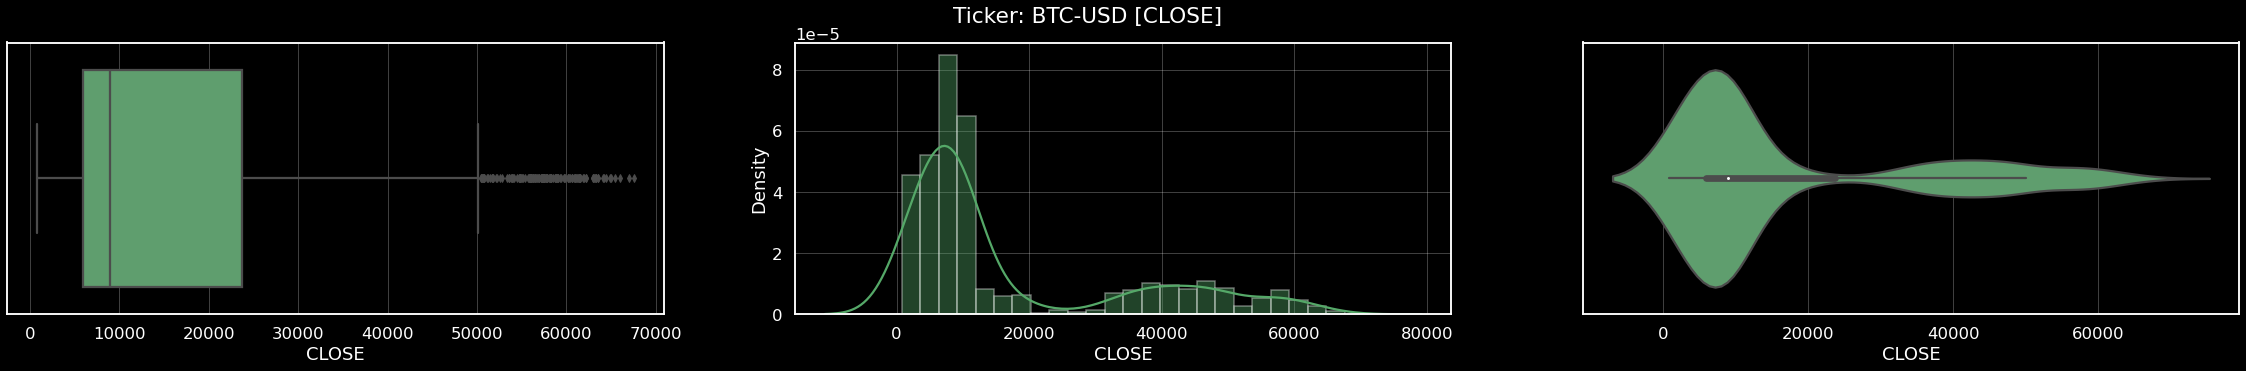

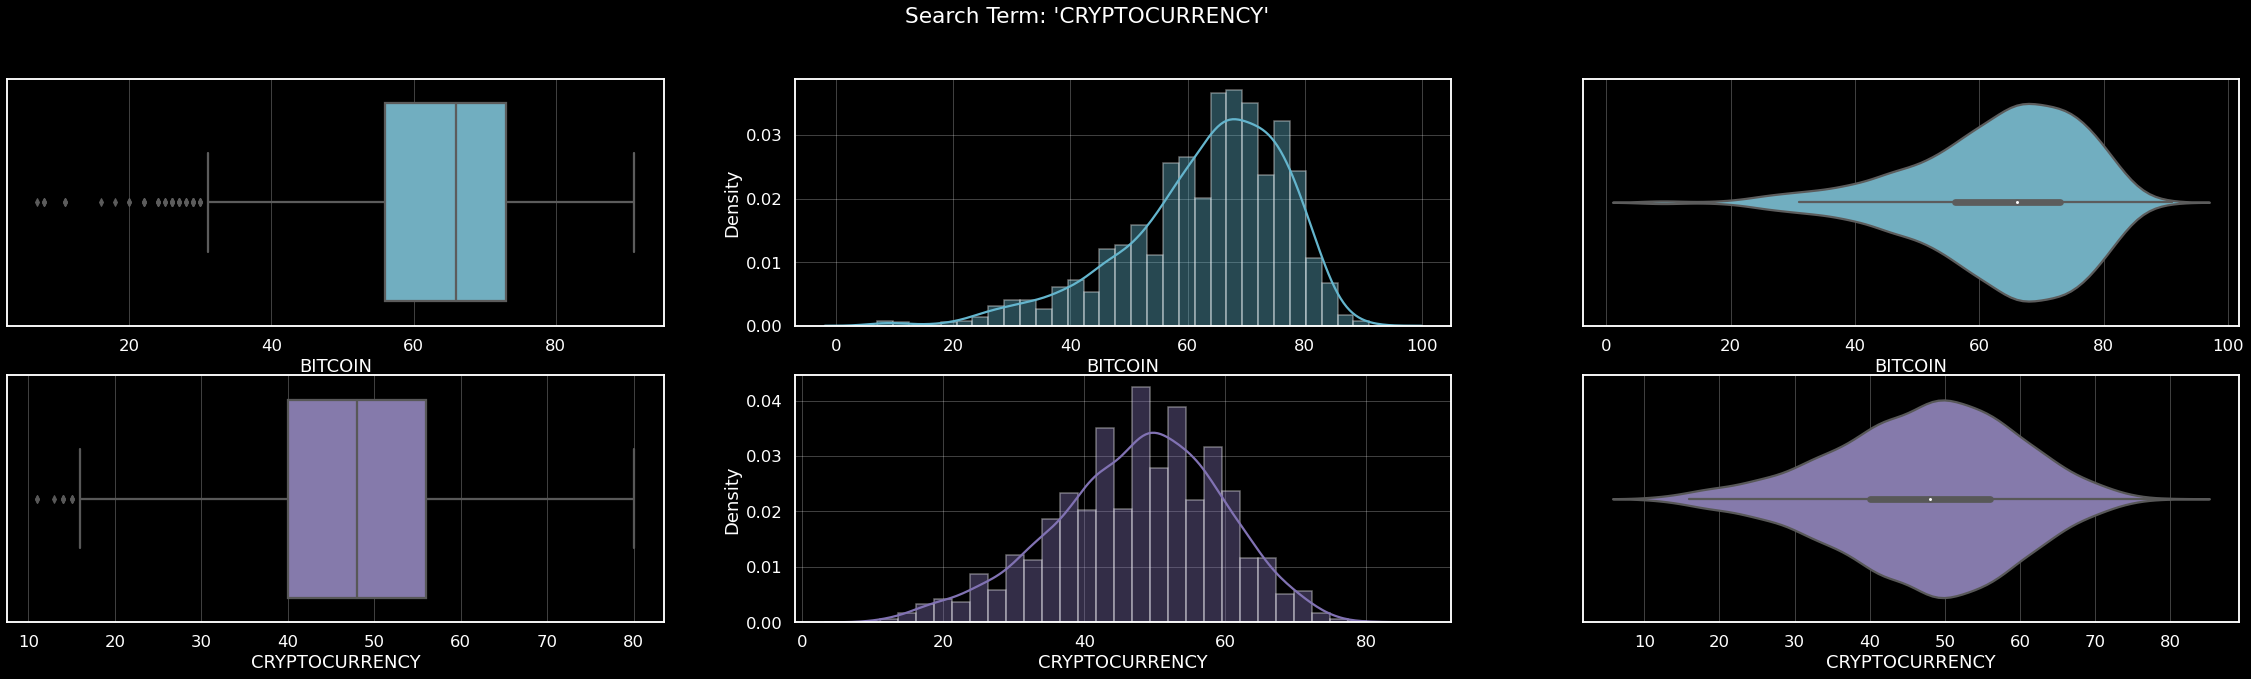

In [140]:
data = deepcopy(rawData)
# Filter out predictor columns (Search Terms)
tickerCols = ['Open','High','Low','Close','Volume']
searchCols = list(set(rawData.columns)-set(t.upper() for t in tickerCols))

fg, ax = plt.subplots(1, 3, figsize=(40, 5))
colors = ["r", "g", "b", "m", "c"]

# Plot ticker visualisations
tickerFocusCol = 'CLOSE' #@param ["CLOSE", "OPEN", "HIGH", "LOW"]{allow-input: true}
plt.suptitle(f"Ticker: {coinTicker} [{tickerFocusCol}]")
sb.boxplot(data[tickerFocusCol], orient = "h", color = colors[1], ax = ax[0])
sb.distplot(data[tickerFocusCol], color = colors[1], ax = ax[1])
sb.violinplot(data[tickerFocusCol], color = colors[1], ax = ax[2])

# Plot trend visualisations
fg, ax = plt.subplots(len(searchCols), 3, figsize=(40, 5*len(searchCols)))
for idx, col in enumerate(searchCols):
  focusCol = col

  plt.suptitle(f"Search Term: '{focusCol}'")
  sb.boxplot(data[focusCol], orient = "h", color = colors[len(colors)-1-idx], ax = ax[idx, 0] if len(searchCols) > 1 else ax[0])
  sb.distplot(data[focusCol], color = colors[len(colors)-1-idx], ax = ax[idx, 1] if len(searchCols) > 1 else ax[1])
  sb.violinplot(data[focusCol], color = colors[len(colors)-1-idx], ax = ax[idx, 2] if len(searchCols) > 1 else ax[2])


### Time Series Visualisation
*Examining the trends over time*

[Text(0.5, 1.0, 'BTC-USD')]

[Text(0.5, 1.0, 'Search Trend #1')]

[Text(0.5, 1.0, 'Search Trend #2')]

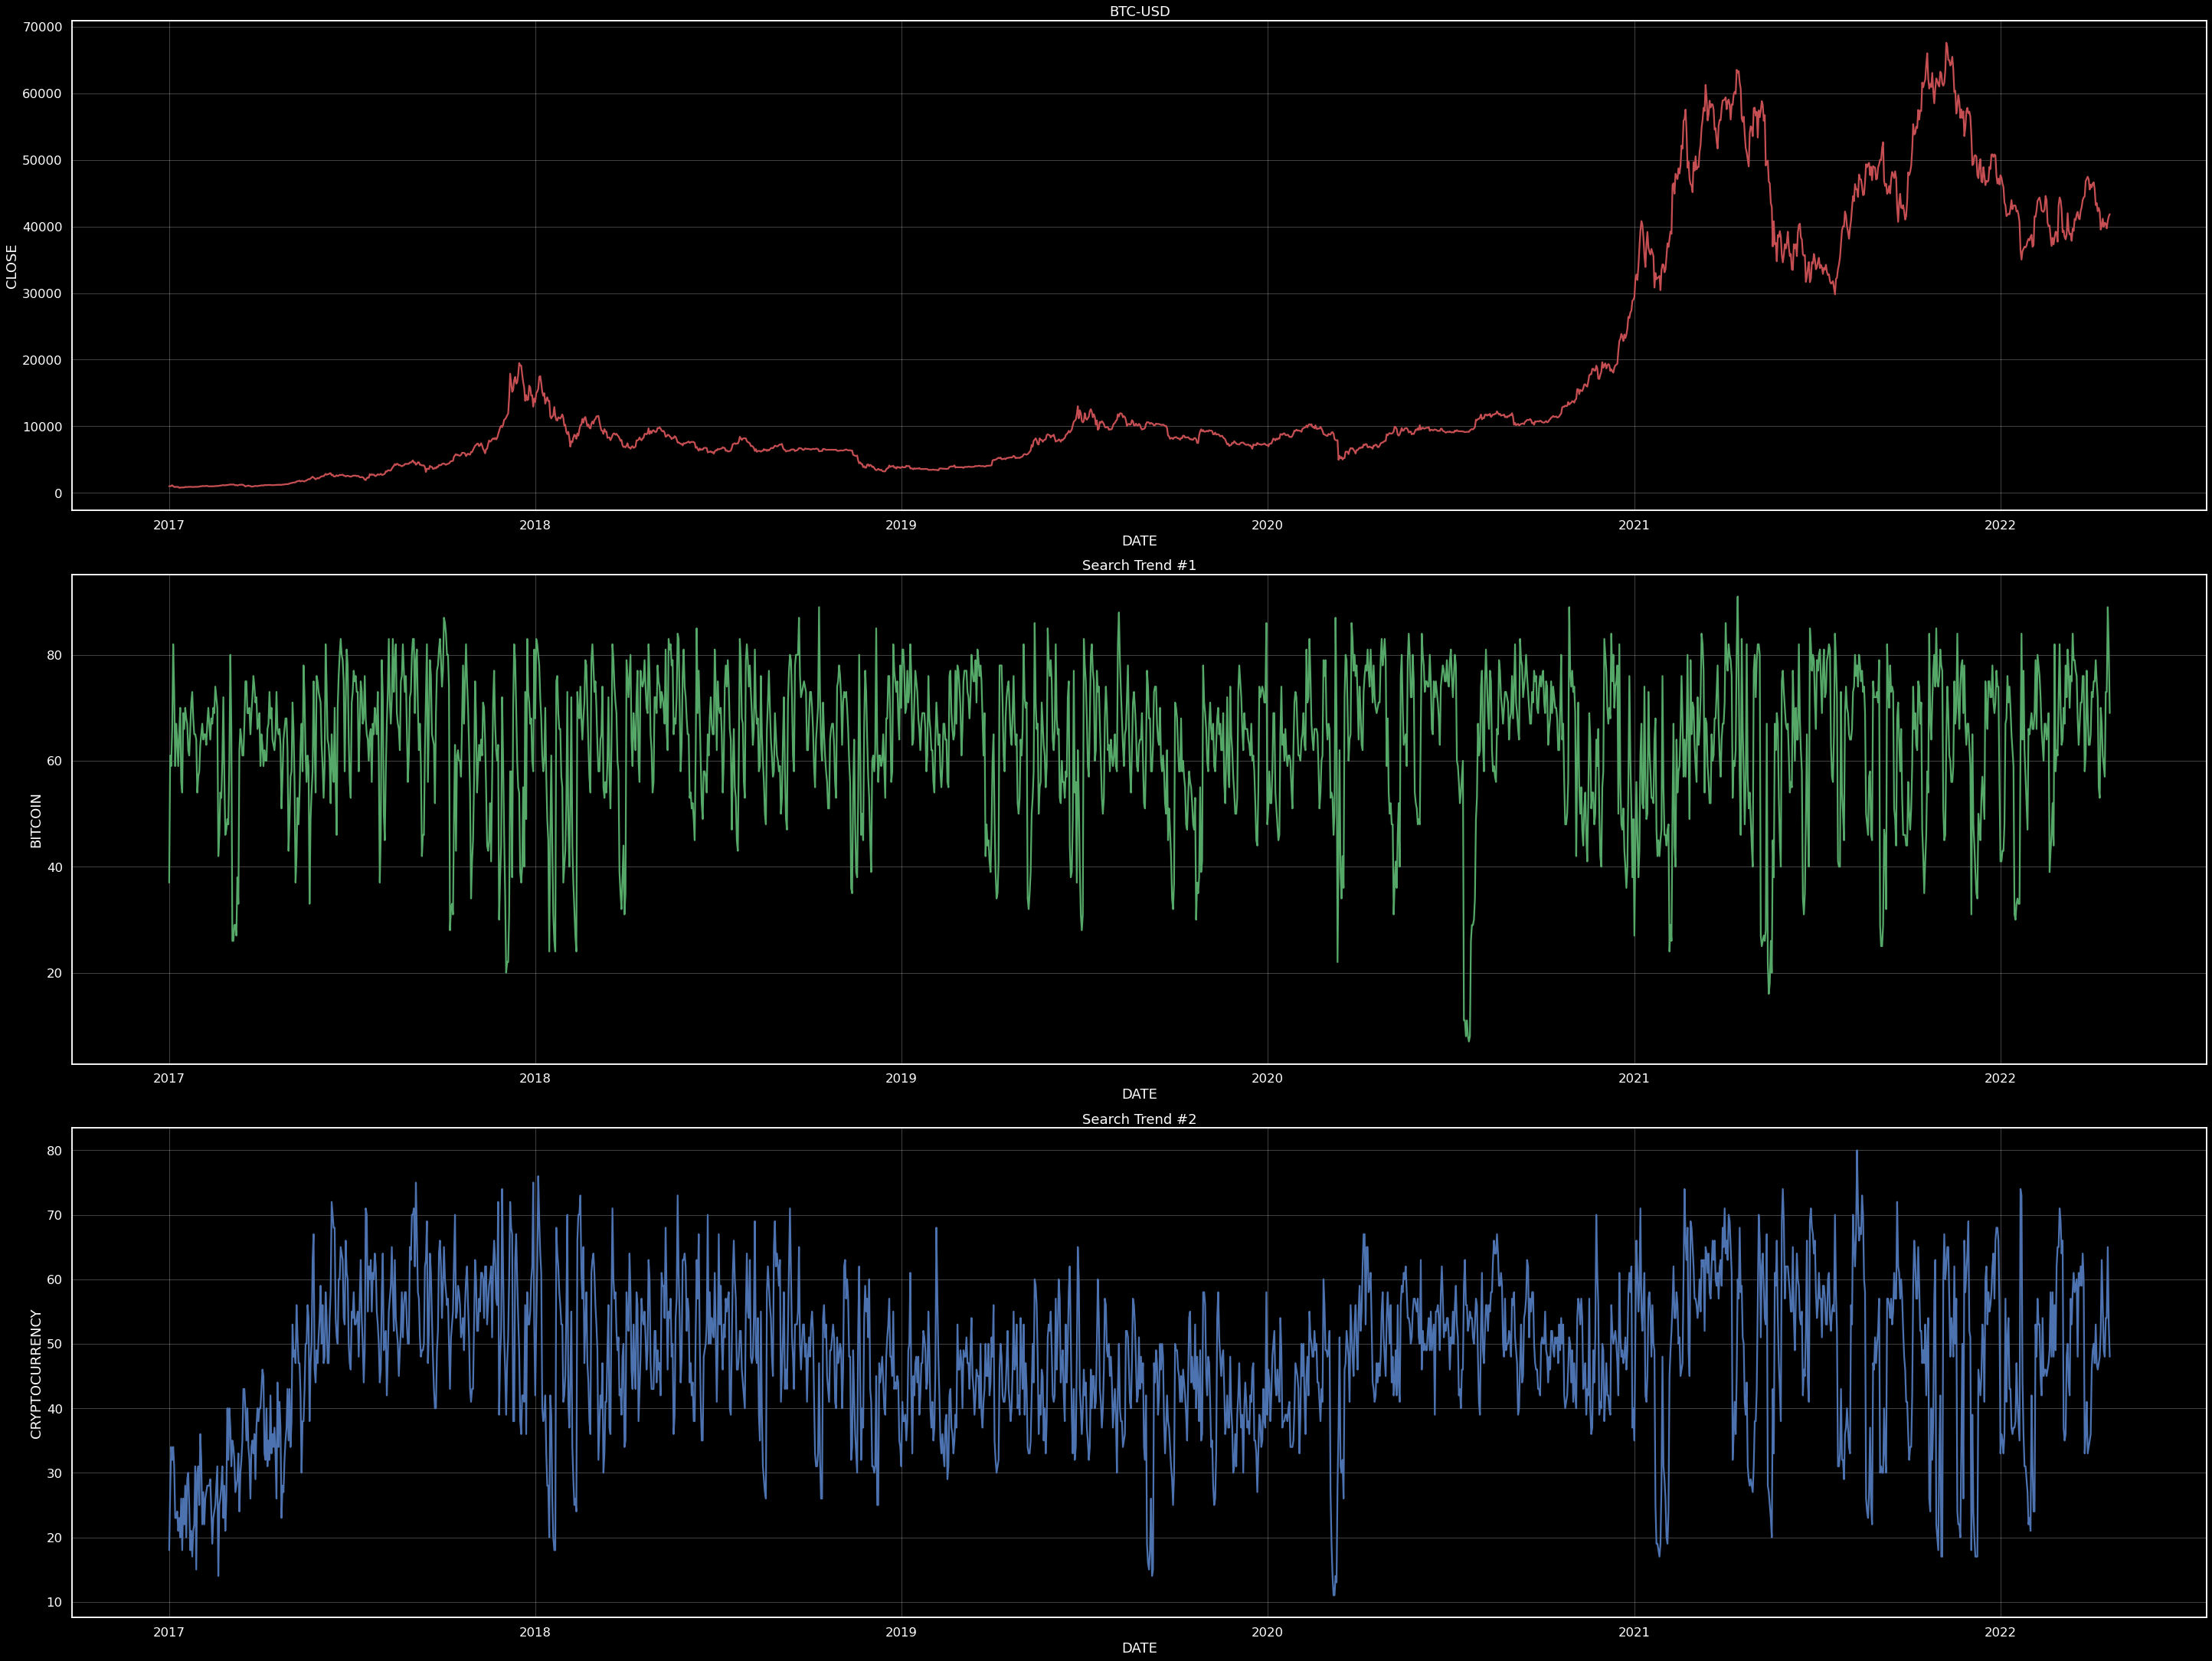

In [141]:
data = deepcopy(rawData)

varCols = [tickerFocusCol, *searchCols]
fg, ax = plt.subplots(len(varCols), 1, figsize=(40, 10*len(varCols)), constrained_layout = True)
for idx, col in enumerate(varCols):
  sb.lineplot(data=data[col], color=colors[idx], ax=ax[idx]).set(title = f"{coinTicker if col == tickerFocusCol else f'Search Trend #{idx}'}")

### Search Percentile Range
*Visualisation the IQR of the search trends*

BITCOIN                          CRYPTOCURRENCY                         
         min   max median  mean   std            min   max median  mean   std
DATE                                                                         
2017   20.00 87.00  65.00 62.86 13.02          14.00 75.00  49.00 46.58 13.98
2018   24.00 89.00  66.00 64.24 12.45          18.00 76.00  49.00 48.81 10.85
2019   28.00 88.00  64.00 62.99 11.72          14.00 68.00  43.00 42.71  8.25
2020    7.00 89.00  67.00 63.91 14.72          11.00 70.00  50.00 48.95  8.72
2021   16.00 91.00  64.00 61.28 15.37          17.00 80.00  54.00 50.23 14.60
2022   30.00 89.00  67.00 64.94 13.01          21.00 74.00  47.50 47.11 11.85

[Text(0.5, 1.0, 'Search Trend #0')]

[Text(0.5, 1.0, 'Search Trend #1')]

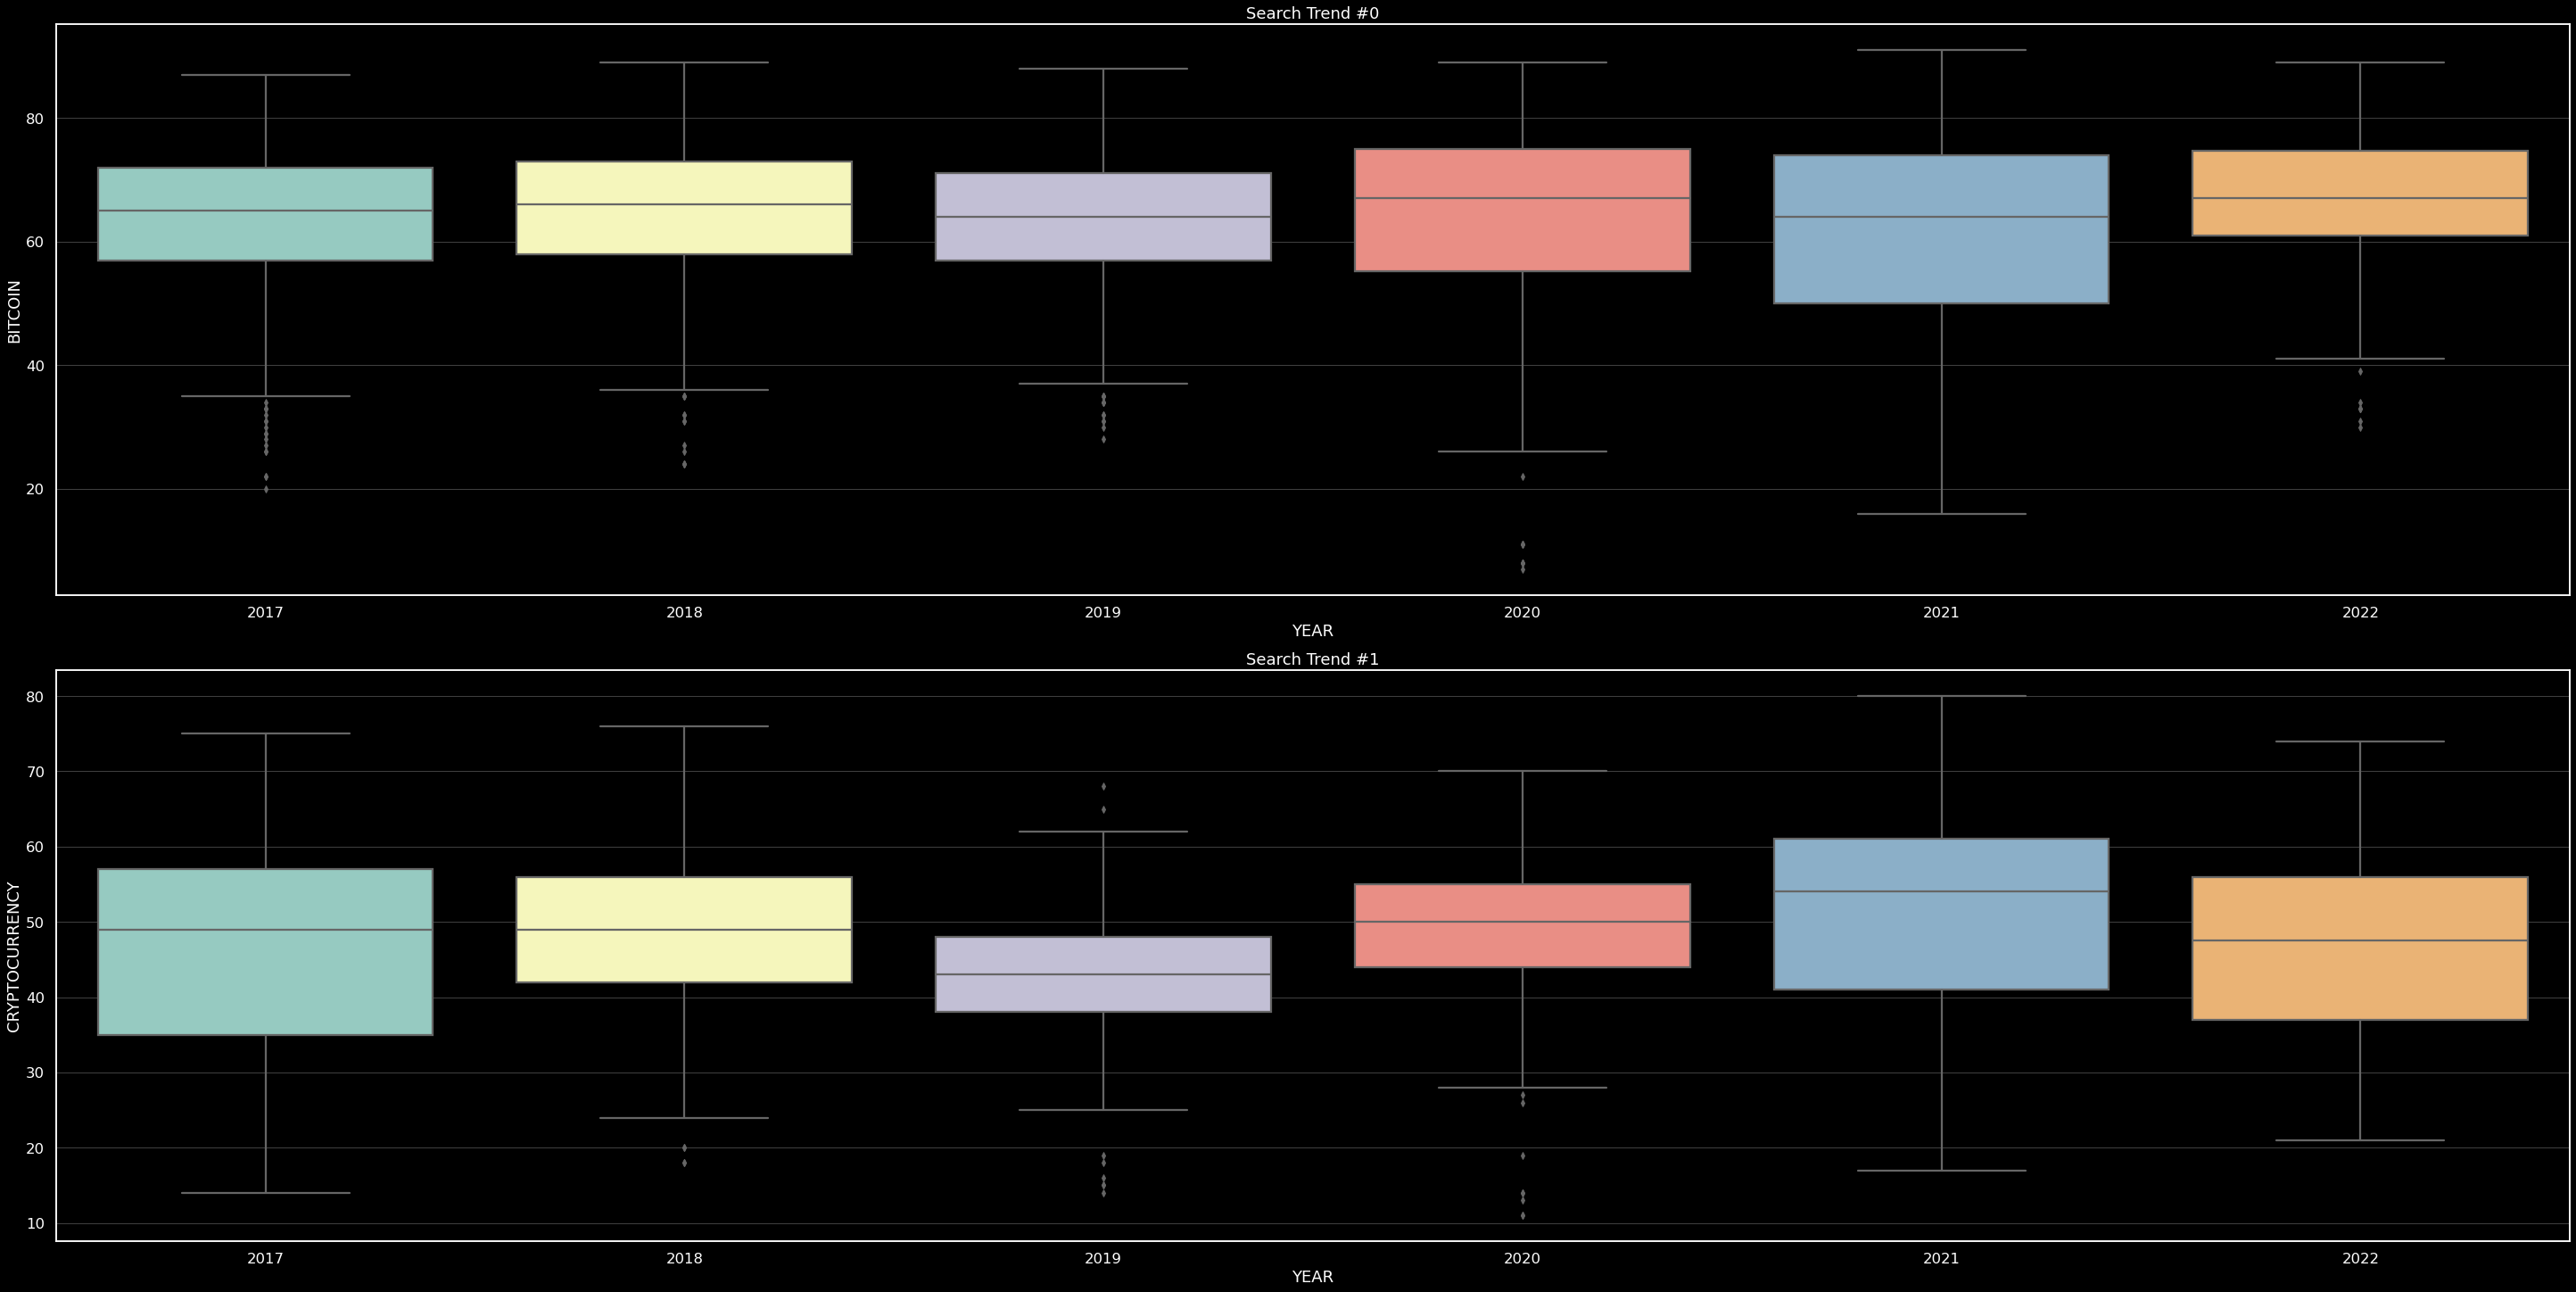

In [142]:
data = deepcopy(rawData)[searchCols]

# # data['Date'.upper()].dt.year
data.groupby(data.index.year).agg(['min', 'max', 'median', 'mean', 'std'])

data['YEAR'] = data.index.year
data.reset_index(inplace=True)

fg, ax = plt.subplots(len(searchCols), 1, figsize=(40, 10*len(searchCols)), constrained_layout = True)
for idx, col in enumerate(searchCols):
  sb.boxplot(data=data, x='YEAR', y=col, ax=ax[idx]).set(title = f"Search Trend #{idx}")

### Ticker OHLC Plot 
*Candlestick visualisation of ticker info (OPEN, HIGH, LOW, CLOSE)*


In [143]:
data = deepcopy(rawData)
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['OPEN'],
                high=data['HIGH'],
                low=data['LOW'],
                close=data['CLOSE'])])

fig.update_layout(
    title=f"{coinTicker} {tickerFocusCol}",
    yaxis_title=f"{coinTicker.split('-')[1]}",
    shapes = [dict(
        x0='2020-12-01', x1='2020-12-01', y0=0, y1=1, xref='x', yref='paper',
        line_width=1)],
    annotations=[dict(
        x='2020-12-01', y=0.05, xref='x', yref='paper',
        showarrow=False, xanchor='left', text='Increase Period Begins')]
)

### Daily Percentage Change
*Feature engineering with Daily Average Search Percentile*


Text(0.5, 1.0, 'Change in BTC-USD [CLOSE] & Search Trend')

[Text(0, 0.5, '% Change'), Text(0.5, 0, 'Date')]

<AxesSubplot:title={'center':'Change in BTC-USD [CLOSE] & Search Trend'}, xlabel='Date', ylabel='% Change'>

<AxesSubplot:title={'center':'Change in BTC-USD [CLOSE] & Search Trend'}, xlabel='Date', ylabel='% Change'>

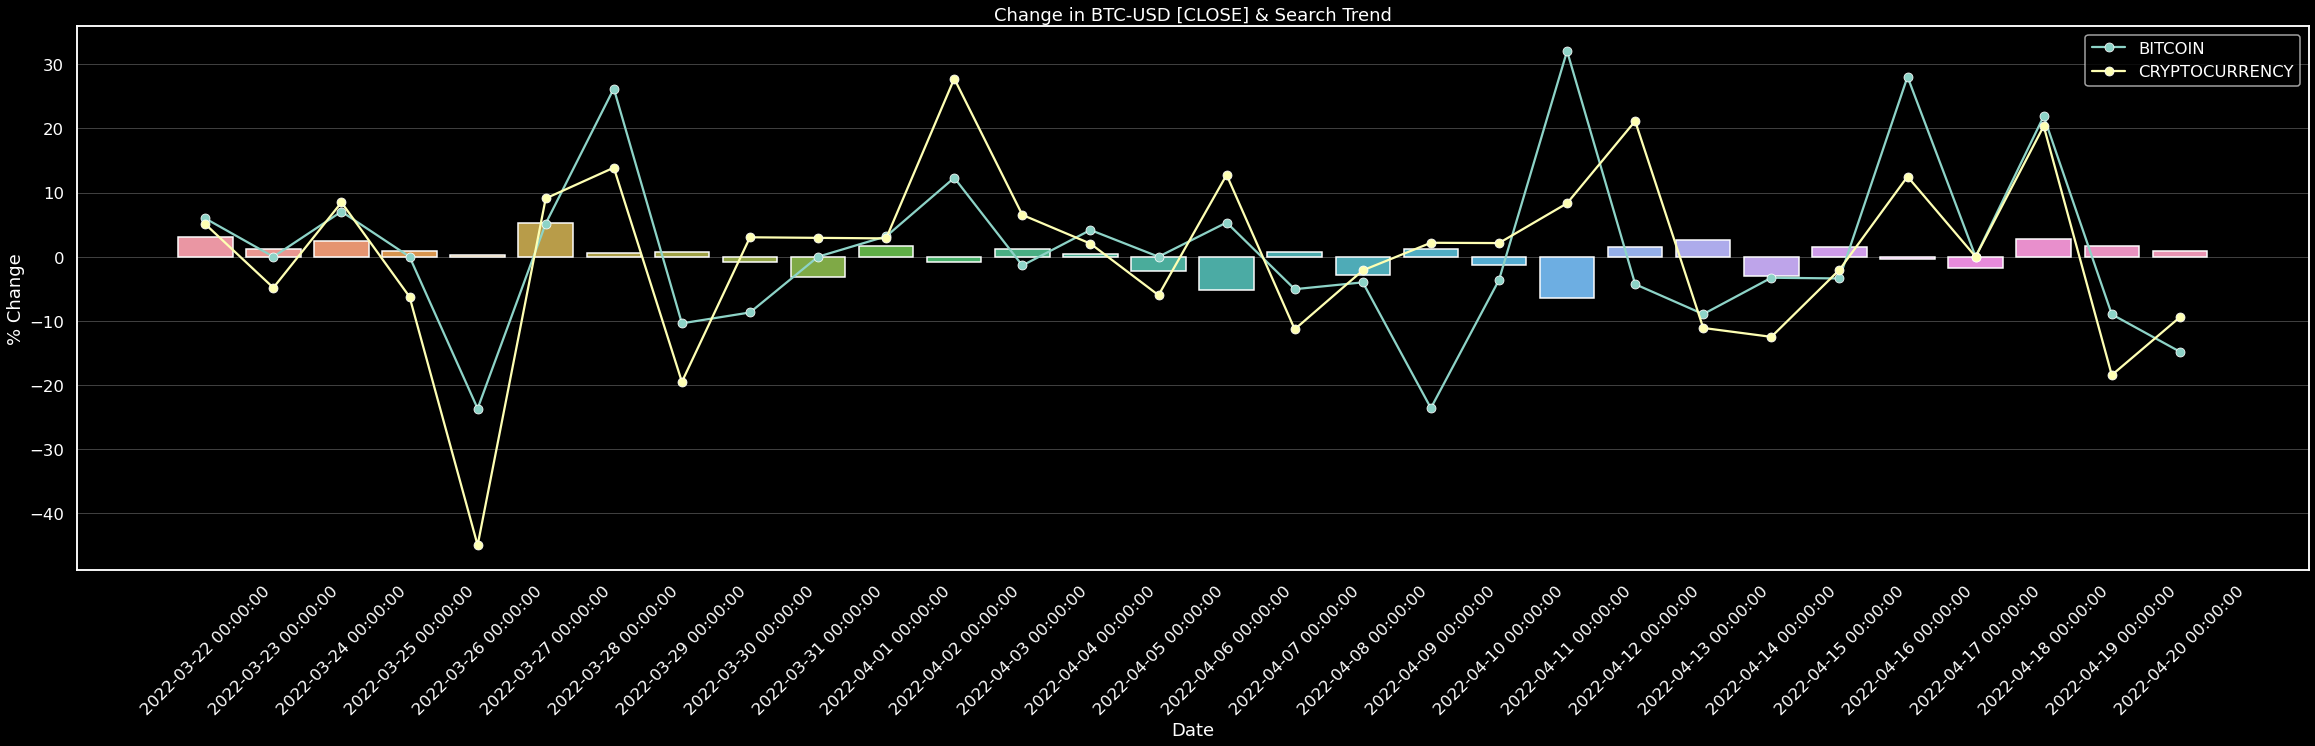

In [144]:
data = deepcopy(rawData)
changeData = deepcopy(data).pct_change(periods=1)*100

ticker = deepcopy(changeData)[[tickerFocusCol]]
trend = deepcopy(changeData)[searchCols]

# Scope the last 30 rows
changeData = changeData.iloc[-30:]

fig, ax = plt.subplots(figsize = (40, 10))
ax.set_title(f"Change in {coinTicker} [{tickerFocusCol}] & Search Trend")

p1 = sb.barplot(data=changeData, x=changeData.index, y=tickerFocusCol, ax=ax)
p1.set(ylabel='% Change', xlabel='Date')
p1 = p1.set_xticklabels(ax.get_xticklabels(), rotation=45)

# get the xtick locations
xticks = ax.get_xticks()
# Plot trend visualisations
for idx, col in enumerate(searchCols):
  focusCol = col
  sb.lineplot(data=changeData, x=xticks, y=focusCol, marker='o', ax=ax, label =focusCol)

plt.show()

### Data Correlation
*The relationship between each variable*

<AxesSubplot:>

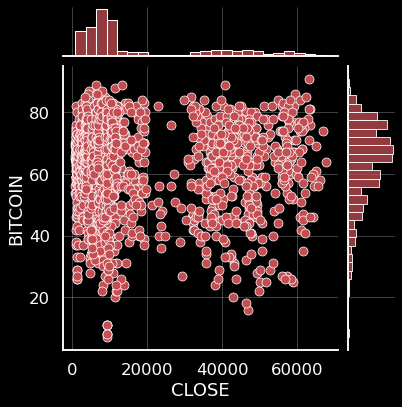

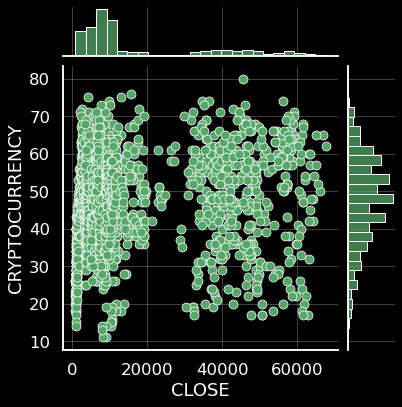

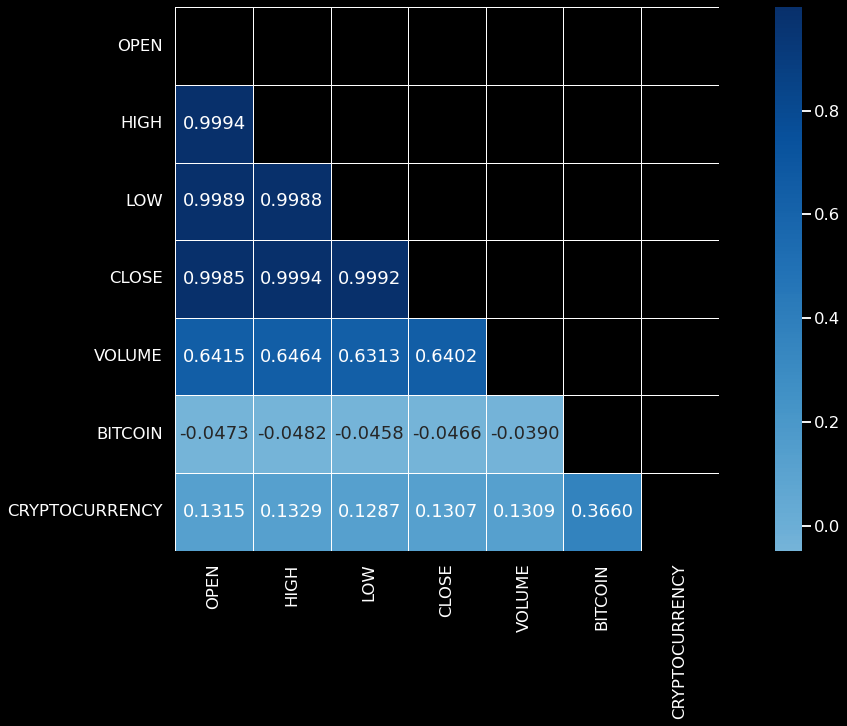

In [145]:
data = deepcopy(rawData)

# fg, ax = plt.subplots(1, len(searchCols), figsize=(40, 10*len(searchCols)), constrained_layout = True)
for idx, col in enumerate(searchCols):
#   sb.jointplot(data=data,x=tickerFocusCol, y=col).set(title = f"Search Trend #{idx}")
    sb.jointplot(x = data[tickerFocusCol], y = data[col], color = colors[idx])


# Correlation
corrData = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corrData, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fg, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corrData, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5, cmap="Blues")

### Scaled Time-Series Visualisation
*Examine the scaled ticker to trend over time*

,CLOSE,CLOSE-SCALED,BITCOIN,CRYPTOCURRENCY
DATE,,,,
2017-01-01,998.33,0.33,37.00,18.00
2017-01-02,"1,021.75",0.37,61.00,27.00
2017-01-03,"1,043.84",0.40,59.00,34.00
2017-01-04,"1,154.73",0.56,66.00,32.00
2017-01-05,"1,013.38",0.35,82.00,34.00
...,...,...,...,...
2022-04-16,"40,424.48",59.36,73.00,54.00
2022-04-17,"39,716.95",58.30,73.00,54.00
2022-04-18,"40,826.21",59.96,89.00,65.00


<AxesSubplot:xlabel='DATE', ylabel='CLOSE-SCALED'>

<AxesSubplot:xlabel='DATE', ylabel='CLOSE-SCALED'>

<AxesSubplot:xlabel='DATE', ylabel='CLOSE-SCALED'>

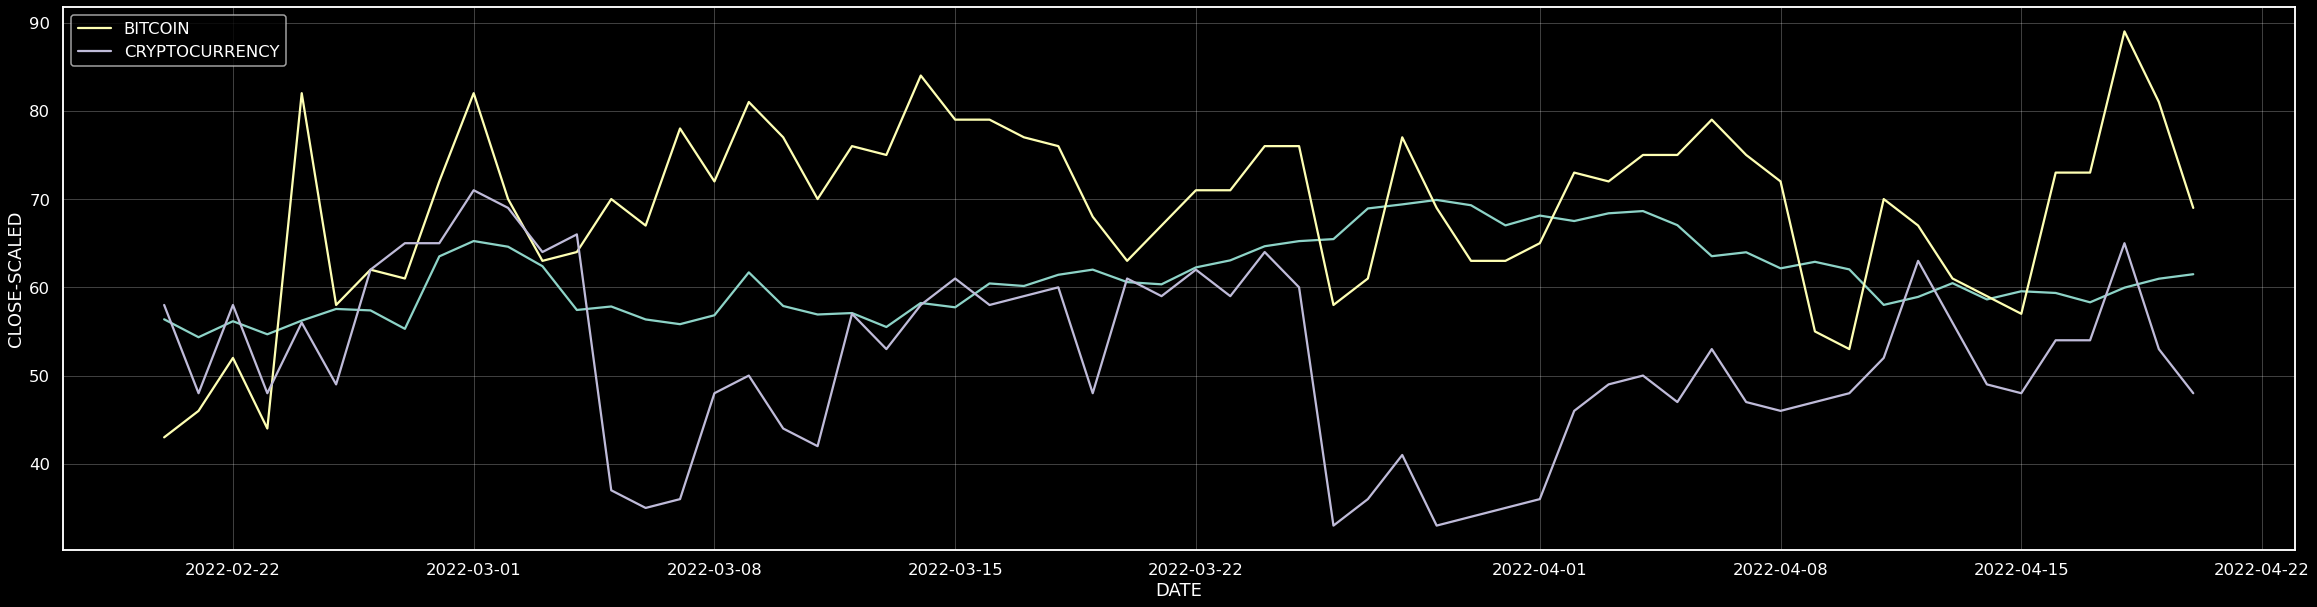

In [146]:
scaledData = deepcopy(rawData)[[tickerFocusCol, *searchCols]]

# Normalize Ticker dataset
ticker = deepcopy(rawData)[[tickerFocusCol]]
scaledTicker = (MinMaxScaler().fit_transform(ticker.values.reshape(-1, 1))) * 100
scaledData[f"{tickerFocusCol}-SCALED"] = scaledTicker

# Rearrange columns
cols = list(scaledData.columns)
cols = cols[0::3] + cols[1:-1]
scaledData = scaledData[cols]
scaledData

# Scope the last 30 rows
# data = scaledData.iloc[-60:]
data = deepcopy(scaledData)[[col for col in scaledData.columns if col != tickerFocusCol]]

showTimeRange = False #@param {type:"boolean"}

if showTimeRange:
  fig = px.line(data, x=data.index, y=data.columns, title=f'{coinTicker} Prediction Comparison')
  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1m", step="month", stepmode="backward"),
              dict(count=6, label="6m", step="month", stepmode="backward"),
              dict(count=1, label="YTD", step="year", stepmode="todate"),
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
else:
  data = data.iloc[-60:]
  fg, ax = plt.subplots(figsize=(40, 10))
  sb.lineplot(data=data, x=data.index, y=f"{tickerFocusCol}-SCALED")

  # Plot trend visualisations
  for idx, col in enumerate(searchCols):
    focusCol = col
    sb.lineplot(data=data, x=data.index, y=focusCol, ax=ax, label=focusCol)


#### Scaled Data Correlation
*The relationship between each variable*

<AxesSubplot:>

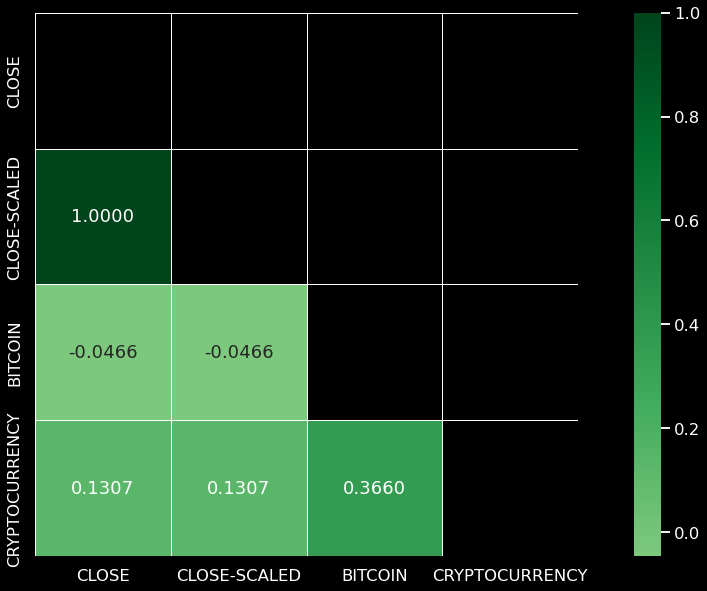

In [147]:
data = deepcopy(scaledData)

# Correlation
corrData = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corrData, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fg, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corrData, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5, cmap="Greens")

---

<p align="center" style="font-style:italic;">END OF NOTEBOOK</p>

<div style="display:flex; flex-direction:row; justify-content:space-between">
    <a href="./0_DataScraper.ipynb" target="_blank">Data Scraper</a>
    <a href="./2_UnivariateForecast.ipynb" target="_blank">Univariate Forecast</a>
</div>